In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

2024-11-12 22:24:52.913525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731430493.477766  331895 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731430493.722957  331895 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 22:24:55.813878: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset_dir = "/mnt/HDD/Programs/Python/SelfDrivingCar/dataset/"
training_dir = dataset_dir + "track1_d4/training/"
validation_dir = dataset_dir + "track1_d2/validation/"
driving_log = "driving_log.csv"

In [3]:
training_df = pd.read_csv(training_dir + driving_log, names=["center", "left", "right", "steering", "throttle", "brake", "speed"])
validation_df = pd.read_csv(validation_dir + driving_log, names=["center", "left", "right", "steering", "throttle", "brake", "speed"])

In [4]:
training_df.head()

,center,left,right,steering,throttle,brake,speed
0,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,0.0,0.0,0,0.553173
1,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,0.0,0.0,0,0.727775
2,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,0.0,0.0,0,0.857716
3,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,0.0,0.0,0,1.029280
4,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,0.0,0.0,0,1.156651


In [5]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3085 entries, 0 to 3084
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   center    3085 non-null   object 
 1   left      3085 non-null   object 
 2   right     3085 non-null   object 
 3   steering  3085 non-null   float64
 4   throttle  3085 non-null   float64
 5   brake     3085 non-null   int64  
 6   speed     3085 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 168.8+ KB


In [6]:
validation_df.head()

,center,left,right,steering,throttle,brake,speed
0,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,0.0,0.000000,0,0.000004
1,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,0.0,0.054035,0,0.014885
2,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,0.0,0.212862,0,0.118003
3,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,0.0,0.472313,0,0.463757
4,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,/mnt/HDD/Programs/Python/SelfDrivingCar/datase...,0.0,0.677288,0,0.890477


In [7]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885 entries, 0 to 884
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   center    885 non-null    object 
 1   left      885 non-null    object 
 2   right     885 non-null    object 
 3   steering  885 non-null    float64
 4   throttle  885 non-null    float64
 5   brake     885 non-null    int64  
 6   speed     885 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 48.5+ KB


In [8]:
trim_size = math.inf

In [9]:
def read_images(df):
    images = []
    for i in range(len(df)):
        center = cv.imread(df.iloc[i]["center"])
        left = cv.imread(df.iloc[i]["left"])
        right = cv.imread(df.iloc[i]["right"])
        images.append(center)
        images.append(left)
        images.append(right)
    return images

In [10]:
def read_steeringAngles(df):
    steeringAngles = []
    for i in range(min(len(df), trim_size)):
        steeringAngles.append(df.iloc[i]["steering"])
        steeringAngles.append(df.iloc[i]["steering"] + 0.2)
        steeringAngles.append(df.iloc[i]["steering"] - 0.2)
    return steeringAngles

In [11]:
training_images = read_images(training_df)
training_steeringAngles = read_steeringAngles(training_df)


In [12]:
validation_images = read_images(validation_df)
validation_steeringAngles = read_steeringAngles(validation_df)

In [13]:
def preprocess_image(image):

    # crop image to show only road
    image = image[60:135, :, :]

    # change color space to YUV to emphasize the road boundary
    image = cv.cvtColor(image, cv.COLOR_BGR2YUV)

    # apply gaussian blur to reduce noise
    image = cv.GaussianBlur(image, (3, 3), 0)

    # resize image to 200x66 for Nvidia Model
    image = cv.resize(image, (200, 66))
    image = image / 255
    return image

In [14]:
len(training_images)

9255

In [15]:
# training_images_preprocessed = np.array([preprocess_image(image) for image in training_images])
training_images_preprocessed = np.array([preprocess_image(image) for image in training_images])

In [16]:
validation_images_preprocessed = np.array([preprocess_image(image) for image in validation_images])

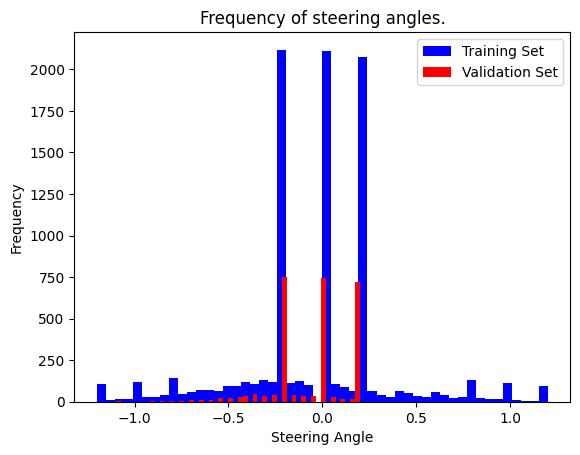

In [17]:
# plot the steering angles in the training set and validation set
plt.hist(training_steeringAngles, bins=50, color='blue', label='Training Set')
plt.hist(validation_steeringAngles, bins=50, color='red', label='Validation Set')
plt.title("Frequency of steering angles.")
plt.xlabel('Steering Angle')
plt.ylabel('Frequency')
plt.legend()


In [18]:
def NvidiaModel():
  model = Sequential()
  model.add(Conv2D(24,(5,5),strides=(2,2),input_shape=(66,200,3),activation="elu"))
  model.add(Conv2D(36,(5,5),strides=(2,2),activation="elu"))
  model.add(Conv2D(48,(5,5),strides=(2,2),activation="elu")) 
  model.add(Conv2D(64,(3,3),activation="elu"))   
  model.add(Conv2D(64,(3,3),activation="elu"))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100,activation="elu"))
  model.add(Dropout(0.5))
  model.add(Dense(50,activation="elu"))
  model.add(Dropout(0.5))
  model.add(Dense(10,activation="elu"))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.compile(optimizer=Adam(learning_rate=1e-3),loss="mse")
  return model

In [19]:
model = NvidiaModel()
model.summary()

/mnt/HDD/Programs/Python/SelfDrivingCar/project-2/carenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1731430829.660558  331895 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2605 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,219 (985.23 KB)

 Trainable params: 252,219 (985.23 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
len(training_images_preprocessed)

9255

In [20]:
history = model.fit(training_images_preprocessed, np.array(training_steeringAngles), epochs=20, validation_data=(validation_images_preprocessed, np.array(validation_steeringAngles)))

: 

In [ ]:
model.save("model2.keras")